loading all the important libraries

In [578]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import holidays

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dropout, Dense
from tensorflow.keras.layers import LSTM, Dropout, Dense

Loading all datasets

In [579]:
DATA1 = pd.read_excel(r"CALCULATION FORECAST ACCURACY.xlsx")
DATA2 = pd.read_excel(r"Invoice modified data-V4.xls")

understanding the DATASETS and cleaning the data

In [580]:
DATA1.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,Part No.,Forecast,Actual Dispatched,Difference =(Forecast-actual),Error Percentage
1,33575-0K080,3993,2880,1113,27.88
2,15677-0E020,8451,6628,1823,21.58
3,16321-0E020,8451,6630,1821,21.55
4,25624-0E020,8451,6660,1791,21.2


In [581]:
DATA2.head()

,Invoice No,Invoice Date,Customer Code,Item No,Shipping Qty,Unit Price,Sub Total,Discount Rate,Discount Amount,Total Excl. Duty,Assessable Value,IGST,SGST,CGST,Grand Total
0,KMI/22-23/0904,2023-01-02,TIEI-02,33575-0K080,120,535.98,64317.60,0,0,64317.60,64317.60,0.0,9004.46,9004.46,82326.52
1,KMI/22-23/0905,2023-01-02,TIEI-02,15677-0E02000,136,282.49,38418.64,0,0,38418.64,38418.64,0.0,5378.61,5378.61,49175.86
2,KMI/22-23/0905,2023-01-02,TIEI-02,16321-0E02000,140,280.10,39214.00,0,0,39214.00,39214.00,0.0,5489.96,5489.96,50193.92
3,KMI/22-23/0905,2023-01-02,TIEI-02,25624-0E02000,144,104.10,14990.40,0,0,14990.40,14990.40,0.0,2098.66,2098.66,19187.72
4,KMI/22-23/0905,2023-01-02,TIEI-02,11151-0E02000,34,137.79,4684.86,0,0,4684.86,4854.86,0.0,679.68,679.68,6044.22


In [582]:
DATA1.shape

(23, 5)

In [583]:
DATA2.shape

(10734, 15)

In [584]:
DATA2.isnull().sum()

Invoice No          0
Invoice Date        0
Customer Code       0
Item No             0
Shipping Qty        0
Unit Price          0
Sub Total           0
Discount Rate       0
Discount Amount     0
Total Excl. Duty    0
Assessable Value    0
IGST                0
SGST                0
CGST                0
Grand Total         0
dtype: int64

In [585]:
DATA2.duplicated(keep="first").sum()

2

In [586]:
DATA2.duplicated(keep=False).sum()

3

In [587]:
duplicates = DATA2[DATA2.duplicated(keep="first")]
print(duplicates)

         Invoice No Invoice Date Customer Code           Item No  \
703  KMI/22-23/1143   2023-02-24        AKL-03  JIG-223111-41340   
704  KMI/22-23/1143   2023-02-24        AKL-03  JIG-223111-41340   

     Shipping Qty  Unit Price  Sub Total  Discount Rate  Discount Amount  \
703             1    270000.0   270000.0              0                0   
704             1    270000.0   270000.0              0                0   

     Total Excl. Duty  Assessable Value  IGST     SGST     CGST  Grand Total  
703          270000.0          270000.0   0.0  24300.0  24300.0     318600.0  
704          270000.0          270000.0   0.0  24300.0  24300.0     318600.0  


In [588]:
DATA2.drop_duplicates(keep='last', inplace=True)

In [589]:
DATA2.duplicated().sum()

0

Starting the feature engineering

1) 1st feature Seasonality features

In [590]:
holiday_s = holidays.India(years = [2023, 2025])
holiday_dates = list(holiday_s.keys())

In [591]:
print(holiday_dates)

[datetime.date(2025, 1, 26), datetime.date(2025, 8, 15), datetime.date(2025, 10, 2), datetime.date(2025, 5, 12), datetime.date(2025, 10, 20), datetime.date(2025, 8, 16), datetime.date(2025, 4, 10), datetime.date(2025, 2, 26), datetime.date(2025, 11, 5), datetime.date(2025, 7, 6), datetime.date(2025, 9, 5), datetime.date(2025, 3, 31), datetime.date(2025, 6, 7), datetime.date(2025, 4, 18), datetime.date(2025, 12, 25), datetime.date(2023, 1, 26), datetime.date(2023, 8, 15), datetime.date(2023, 10, 2), datetime.date(2023, 5, 5), datetime.date(2023, 11, 12), datetime.date(2023, 9, 7), datetime.date(2023, 10, 24), datetime.date(2023, 4, 4), datetime.date(2023, 2, 18), datetime.date(2023, 11, 27), datetime.date(2023, 7, 29), datetime.date(2023, 9, 28), datetime.date(2023, 4, 22), datetime.date(2023, 6, 29), datetime.date(2023, 4, 7), datetime.date(2023, 12, 25)]


In [592]:
holiday_dates = pd.to_datetime(holiday_dates)
DATA2['is_holiday'] = np.where(DATA2['Invoice Date'].isin(holiday_dates), 1, 0)

2) 2nd feature time-series data

In [593]:
DATA2['month'] = DATA2['Invoice Date'].dt.month
DATA2["day"] = DATA2["Invoice Date"].dt.day
DATA2["year"] = DATA2["Invoice Date"].dt.year

In [594]:
DATA2.describe().T

,count,mean,min,25%,50%,75%,max,std
Invoice Date,10732,2024-02-03 03:27:34.416697600,2023-01-02 00:00:00,2023-07-17 00:00:00,2024-02-02 00:00:00,2024-08-16 00:00:00,2025-03-11 00:00:00,NaN
Shipping Qty,10732.0,514.624581,1.0,192.0,312.0,420.0,14300.0,776.922219
Unit Price,10732.0,3977.027173,17.34,139.01,204.11,278.64,4000000.0,96681.589229
Sub Total,10732.0,84080.355557,1000.78,37046.4,65105.45,92995.2,4000000.0,127464.823596
Discount Rate,10732.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Discount Amount,10732.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Total Excl. Duty,10732.0,84080.355557,1000.78,37046.4,65105.45,92995.2,4000000.0,127464.823596
Assessable Value,10732.0,87518.755669,1000.78,37810.72,65823.5,92995.2,4000000.0,133459.5917
IGST,10732.0,1187.340574,0.0,0.0,0.0,0.0,322541.52,17876.662695
SGST,10732.0,11462.24286,0.0,5189.18,9175.28,12940.62,360000.0,13339.806633


Removing the discount attributes as the data is irrelevant 

In [595]:
DATA2.drop(['Invoice No', 'Discount Rate', 'Discount Amount'], axis=1, inplace=True)

In [596]:
DATA2.describe().T

,count,mean,min,25%,50%,75%,max,std
Invoice Date,10732,2024-02-03 03:27:34.416697600,2023-01-02 00:00:00,2023-07-17 00:00:00,2024-02-02 00:00:00,2024-08-16 00:00:00,2025-03-11 00:00:00,NaN
Shipping Qty,10732.0,514.624581,1.0,192.0,312.0,420.0,14300.0,776.922219
Unit Price,10732.0,3977.027173,17.34,139.01,204.11,278.64,4000000.0,96681.589229
Sub Total,10732.0,84080.355557,1000.78,37046.4,65105.45,92995.2,4000000.0,127464.823596
Total Excl. Duty,10732.0,84080.355557,1000.78,37046.4,65105.45,92995.2,4000000.0,127464.823596
Assessable Value,10732.0,87518.755669,1000.78,37810.72,65823.5,92995.2,4000000.0,133459.5917
IGST,10732.0,1187.340574,0.0,0.0,0.0,0.0,322541.52,17876.662695
SGST,10732.0,11462.24286,0.0,5189.18,9175.28,12940.62,360000.0,13339.806633
CGST,10732.0,11462.24286,0.0,5189.18,9175.28,12940.62,360000.0,13339.806633
Grand Total,10732.0,108192.181851,1281.0,47800.2,83888.24,119033.86,4720000.0,157680.236944


3) 3rd feature LAG features

visualizing data to calculate the value of lag to be used.

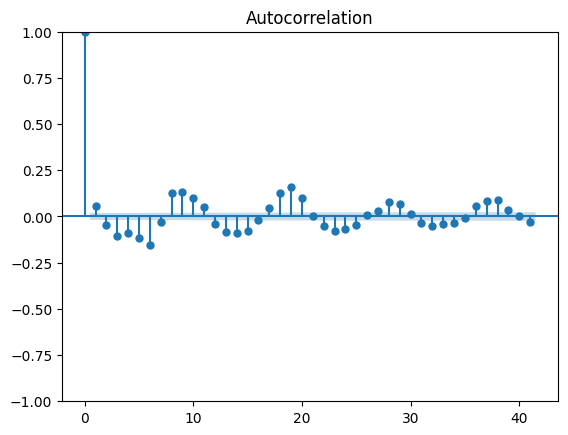

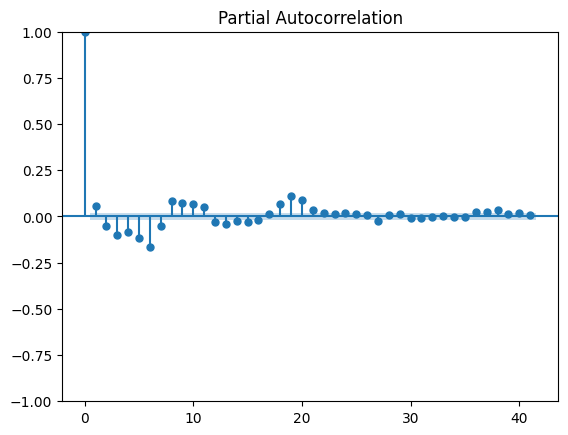

In [597]:
# Assume 'series' is your pandas Series of demand data
plot_acf(DATA2["Shipping Qty"])
plt.show()

plot_pacf(DATA2["Shipping Qty"])
plt.show()

As we can see from the above graphs the DATA shows the best lag to be choosen is 1, any value including 2 and above can also be used but it decreases the correlation between the quantity and time series and hence reduces the models accuracy

In [598]:
DATA2["lag_features"] = DATA2["Shipping Qty"].shift(1)

In [599]:
DATA2.describe().T

,count,mean,min,25%,50%,75%,max,std
Invoice Date,10732,2024-02-03 03:27:34.416697600,2023-01-02 00:00:00,2023-07-17 00:00:00,2024-02-02 00:00:00,2024-08-16 00:00:00,2025-03-11 00:00:00,NaN
Shipping Qty,10732.0,514.624581,1.0,192.0,312.0,420.0,14300.0,776.922219
Unit Price,10732.0,3977.027173,17.34,139.01,204.11,278.64,4000000.0,96681.589229
Sub Total,10732.0,84080.355557,1000.78,37046.4,65105.45,92995.2,4000000.0,127464.823596
Total Excl. Duty,10732.0,84080.355557,1000.78,37046.4,65105.45,92995.2,4000000.0,127464.823596
Assessable Value,10732.0,87518.755669,1000.78,37810.72,65823.5,92995.2,4000000.0,133459.5917
IGST,10732.0,1187.340574,0.0,0.0,0.0,0.0,322541.52,17876.662695
SGST,10732.0,11462.24286,0.0,5189.18,9175.28,12940.62,360000.0,13339.806633
CGST,10732.0,11462.24286,0.0,5189.18,9175.28,12940.62,360000.0,13339.806633
Grand Total,10732.0,108192.181851,1281.0,47800.2,83888.24,119033.86,4720000.0,157680.236944


In [600]:
DATA2.head()

,Invoice Date,Customer Code,Item No,Shipping Qty,Unit Price,Sub Total,Total Excl. Duty,Assessable Value,IGST,SGST,CGST,Grand Total,is_holiday,month,day,year,lag_features
0,2023-01-02,TIEI-02,33575-0K080,120,535.98,64317.60,64317.60,64317.60,0.0,9004.46,9004.46,82326.52,0,1,2,2023,NaN
1,2023-01-02,TIEI-02,15677-0E02000,136,282.49,38418.64,38418.64,38418.64,0.0,5378.61,5378.61,49175.86,0,1,2,2023,120.0
2,2023-01-02,TIEI-02,16321-0E02000,140,280.10,39214.00,39214.00,39214.00,0.0,5489.96,5489.96,50193.92,0,1,2,2023,136.0
3,2023-01-02,TIEI-02,25624-0E02000,144,104.10,14990.40,14990.40,14990.40,0.0,2098.66,2098.66,19187.72,0,1,2,2023,140.0
4,2023-01-02,TIEI-02,11151-0E02000,34,137.79,4684.86,4684.86,4854.86,0.0,679.68,679.68,6044.22,0,1,2,2023,144.0


In [601]:
DATA2.isnull().sum()

Invoice Date        0
Customer Code       0
Item No             0
Shipping Qty        0
Unit Price          0
Sub Total           0
Total Excl. Duty    0
Assessable Value    0
IGST                0
SGST                0
CGST                0
Grand Total         0
is_holiday          0
month               0
day                 0
year                0
lag_features        1
dtype: int64

In [602]:
# Calculate the mean of the column, ignoring NaNs
lag_mean = DATA2['lag_features'].mean()
lag_mean


514.6307893020222

In [603]:
# Replace NaNs with the mean
DATA2['lag_features'] = DATA2['lag_features'].fillna(lag_mean)

In [604]:
DATA2.isnull().sum()

Invoice Date        0
Customer Code       0
Item No             0
Shipping Qty        0
Unit Price          0
Sub Total           0
Total Excl. Duty    0
Assessable Value    0
IGST                0
SGST                0
CGST                0
Grand Total         0
is_holiday          0
month               0
day                 0
year                0
lag_features        0
dtype: int64

4) 4th feature Rolling Average

we have taken the rolling averages of the past 3 months cuz that is the most relevant according to our data.

In [605]:
DATA2['rolling_avg_3'] = DATA2['Shipping Qty'].rolling(window=3).mean()  # 3-period average

In [606]:
DATA2.describe().T

,count,mean,min,25%,50%,75%,max,std
Invoice Date,10732,2024-02-03 03:27:34.416697600,2023-01-02 00:00:00,2023-07-17 00:00:00,2024-02-02 00:00:00,2024-08-16 00:00:00,2025-03-11 00:00:00,NaN
Shipping Qty,10732.0,514.624581,1.0,192.0,312.0,420.0,14300.0,776.922219
Unit Price,10732.0,3977.027173,17.34,139.01,204.11,278.64,4000000.0,96681.589229
Sub Total,10732.0,84080.355557,1000.78,37046.4,65105.45,92995.2,4000000.0,127464.823596
Total Excl. Duty,10732.0,84080.355557,1000.78,37046.4,65105.45,92995.2,4000000.0,127464.823596
Assessable Value,10732.0,87518.755669,1000.78,37810.72,65823.5,92995.2,4000000.0,133459.5917
IGST,10732.0,1187.340574,0.0,0.0,0.0,0.0,322541.52,17876.662695
SGST,10732.0,11462.24286,0.0,5189.18,9175.28,12940.62,360000.0,13339.806633
CGST,10732.0,11462.24286,0.0,5189.18,9175.28,12940.62,360000.0,13339.806633
Grand Total,10732.0,108192.181851,1281.0,47800.2,83888.24,119033.86,4720000.0,157680.236944


In [607]:
DATA2.isnull().sum()

Invoice Date        0
Customer Code       0
Item No             0
Shipping Qty        0
Unit Price          0
Sub Total           0
Total Excl. Duty    0
Assessable Value    0
IGST                0
SGST                0
CGST                0
Grand Total         0
is_holiday          0
month               0
day                 0
year                0
lag_features        0
rolling_avg_3       2
dtype: int64

In [608]:
roll_avg_mean = DATA2['rolling_avg_3'].mean()
roll_avg_mean

514.6750232991612

In [609]:
DATA2['rolling_avg_3'] = DATA2["rolling_avg_3"].fillna(roll_avg_mean)
DATA2.isnull().sum()

Invoice Date        0
Customer Code       0
Item No             0
Shipping Qty        0
Unit Price          0
Sub Total           0
Total Excl. Duty    0
Assessable Value    0
IGST                0
SGST                0
CGST                0
Grand Total         0
is_holiday          0
month               0
day                 0
year                0
lag_features        0
rolling_avg_3       0
dtype: int64

In [610]:
DATA2.head(-10)

,Invoice Date,Customer Code,Item No,Shipping Qty,Unit Price,Sub Total,Total Excl. Duty,Assessable Value,IGST,SGST,CGST,Grand Total,is_holiday,month,day,year,lag_features,rolling_avg_3
0,2023-01-02,TIEI-02,33575-0K080,120,535.98,64317.60,64317.60,64317.60,0.0,9004.46,9004.46,82326.52,0,1,2,2023,514.630789,514.675023
1,2023-01-02,TIEI-02,15677-0E02000,136,282.49,38418.64,38418.64,38418.64,0.0,5378.61,5378.61,49175.86,0,1,2,2023,120.000000,514.675023
2,2023-01-02,TIEI-02,16321-0E02000,140,280.10,39214.00,39214.00,39214.00,0.0,5489.96,5489.96,50193.92,0,1,2,2023,136.000000,132.000000
3,2023-01-02,TIEI-02,25624-0E02000,144,104.10,14990.40,14990.40,14990.40,0.0,2098.66,2098.66,19187.72,0,1,2,2023,140.000000,140.000000
4,2023-01-02,TIEI-02,11151-0E02000,34,137.79,4684.86,4684.86,4854.86,0.0,679.68,679.68,6044.22,0,1,2,2023,144.000000,106.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10719,2025-03-10,AKL-03,223115-41360,420,151.09,63457.80,63457.80,63457.80,0.0,8884.09,8884.09,81225.98,0,3,10,2025,420.000000,376.000000
10720,2025-03-11,TKM-01,23825-F201000,16,147.07,2353.12,2353.12,2353.12,0.0,329.44,329.44,3012.00,0,3,11,2025,420.000000,285.333333
10721,2025-03-11,TIEI-02,33575-0K080,120,535.98,64317.60,64317.60,64317.60,0.0,9004.46,9004.46,82326.52,0,3,11,2025,16.000000,185.333333
10722,2025-03-11,TIEI-02,15677-0E02000,300,282.50,84750.00,84750.00,84750.00,0.0,11865.00,11865.00,108480.00,0,3,11,2025,120.000000,145.333333


In [611]:
#DATA2.to_excel("cleaned_dataset2.xlsx", index=False)

the DATA is properly preprocessed, if the data is prepared or designed as above, it is also recommended to add the error percenatges of each months forecastings to each of the invoice dates, this would improve the models performance.

preparing the data for testing and training

1) Normalization/Scaling

LSTM networks are sensitive to the scale of input data. Large differences in feature scales can hinder learning.

Use normalization (e.g., MinMaxScaler) or standardization (e.g., StandardScaler) to scale all input features to a similar range, typically  or with zero mean and unit variance.

In [612]:
numeric_cols = DATA2.select_dtypes(include=['number'])

# Apply MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(numeric_cols)

# If you want it back as a DataFrame:
scaled_data = pd.DataFrame(scaled_data, columns=numeric_cols.columns)
final_data = pd.concat([DATA2.select_dtypes(exclude=['number']), scaled_data], axis=1)
final_data.drop(columns = ['Invoice Date'], inplace=True)

In [613]:
final_data = pd.get_dummies(final_data, columns=['Item No', 'Customer Code'], dtype=int)

In [614]:
final_data.head(-10)

,Shipping Qty,Unit Price,Sub Total,Total Excl. Duty,Assessable Value,IGST,SGST,CGST,Grand Total,is_holiday,...,Item No_JIG-16575-VT05000,Item No_JIG-223111-41340,Item No_JIG-223115-11970,Item No_JIG-223115-11980,Item No_JIG-223115-41360,Item No_JIG-23825-F201000,Customer Code_AAI-04,Customer Code_AKL-03,Customer Code_TIEI-02,Customer Code_TKM-01
0,0.008322,1.296606e-04,0.015833,0.015833,0.015833,0.0,0.025012,0.025012,0.017175,0.0,...,0,0,0,0,0,0,0,0,1,0
1,0.009441,6.628779e-05,0.009357,0.009357,0.009357,0.0,0.014941,0.014941,0.010150,0.0,...,0,0,0,0,0,0,0,0,1,0
2,0.009721,6.569028e-05,0.009556,0.009556,0.009556,0.0,0.015250,0.015250,0.010366,0.0,...,0,0,0,0,0,0,0,0,1,0
3,0.010001,2.169009e-05,0.003498,0.003498,0.003498,0.0,0.005830,0.005830,0.003795,0.0,...,0,0,0,0,0,0,0,0,1,0
4,0.002308,3.011263e-05,0.000921,0.000921,0.000964,0.0,0.001888,0.001888,0.001009,0.0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10721,0.020911,6.569028e-05,0.020762,0.020762,0.020762,0.0,0.032678,0.032678,0.022523,0.0,...,0,0,0,0,0,0,0,0,1,0
10722,0.020911,2.169009e-05,0.007559,0.007559,0.007559,0.0,0.012145,0.012145,0.008200,0.0,...,0,0,0,0,0,0,0,0,1,0
10723,0.030841,3.128264e-05,0.015497,0.015497,0.015497,0.0,0.024489,0.024489,0.016810,0.0,...,0,0,0,0,0,0,0,0,1,0
10724,0.246101,3.750016e-07,0.016333,0.016333,0.016333,0.0,0.025790,0.025790,0.017718,0.0,...,0,0,0,0,0,0,0,0,1,0


2) Sequence genartion(windowing)

LSTMs expect input data in the form of sequences (windows) of past observations to predict future values.

In [615]:
def create_sequences(data, look_back=3, target_col=0):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i+look_back])
        y.append(data[i+look_back, target_col])
        
    return np.array(X), np.array(y)


In [616]:
X, y = create_sequences(final_data.to_numpy(), look_back=3, target_col=0)
X.shape

(10731, 3, 63)

In [617]:
np.isnan(X).sum()

75

In [618]:
np.isnan(y).sum()

2

In [619]:
mask_X = ~np.isnan(X).any(axis=(1,2))  # True where X row has no NaN
mask_y = ~np.isnan(y)                  # True where y is not NaN
mask = mask_X & mask_y                 # Only keep where both are valid

# Apply mask to both X and y
X = X[mask]
y = y[mask]

np.isnan(X).sum()
np.isnan(y).sum()

0

3) Splitting training and testing data

The popular train_test_split function from scikit-learn is not suitable for time series data because it splits the data randomly by default.

In [620]:
n = len(X)
train_end = int(n * 0.6)
val_end = int(n * 0.8)  # train + val

splitting the data accordingly, 80%, 60%, 20% for training, validation and testing respectively

In [621]:
X_train = X[:train_end]
y_train = y[:train_end]

X_val = X[train_end:val_end]
y_val = y[train_end:val_end]

X_test = X[val_end:]
y_test = y[val_end:]

Model traing

We'll be training and comparing various types of models(common statistical models, machine learning moidls and deep learning models)

1) first will be the common models which we r going for ARIMA/SARIMA

In [622]:
'''arima_model = ARIMA(y_train).fit()
arima_pred = arima_model.predict(start=len(y_train), end=len(y_train)+len(y_test)-1)

# SARIMA (if seasonality is present)
sarima_model = SARIMAX(y_train).fit()
sarima_pred = sarima_model.predict(start=len(y_train), end=len(y_train)+len(y_test)-1)'''

# For ARIMA (non-seasonal)
arima_model = auto_arima(y_train)

# For SARIMA (seasonal)
sarima_model = auto_arima(y_train, seasonal=True, m=12)  # m=seasonal period (e.g., 12 for monthly data)

In [623]:
n_periods = len(y_test)
arima_pred = arima_model.predict(n_periods=n_periods)
sarima_pred = sarima_model.predict(n_periods=n_periods)

2) Decision trees (Machine Learning model)

In [624]:
# Example: If X_train.shape is (n_samples, n_features, 1)
dt_X_train = X_train.reshape(X_train.shape[0], -1)
dt_X_test = X_test.reshape(X_test.shape[0], -1)

dt_model = DecisionTreeRegressor()
dt_model.fit(dt_X_train, y_train)
dt_pred = dt_model.predict(dt_X_test)

3) Random forest (Machine learning model)

In [625]:
rf_model = RandomForestRegressor(n_estimators=100)
rf_model.fit(dt_X_train, y_train)
rf_pred = rf_model.predict(dt_X_test)

4) GRU model (Deep learning model)

In [626]:
gru_model = Sequential()
gru_model.add(GRU(64, activation='tanh', return_sequences=True, input_shape=(3, 63)))
gru_model.add(Dropout(0.2))
gru_model.add(GRU(32, activation='tanh', return_sequences=True))
gru_model.add(Dropout(0.2))
gru_model.add(GRU(16, activation='tanh'))  # Last GRU layer: return_sequences=False (default)
gru_model.add(Dropout(0.2))
gru_model.add(Dense(1))

gru_model.compile(optimizer='adam', loss='mse')

c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [627]:
y_train.shape

(6436,)

In [628]:
'''y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)
'''
# Fit the model
gru_history = gru_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1
)

# Predict on test set
gru_pred = gru_model.predict(X_test)

Epoch 1/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 0.0030 - val_loss: 0.0024
Epoch 2/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 3/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 4/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0014 - val_loss: 0.0018
Epoch 5/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 6/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 7/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 8/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0013 - val_loss: 0.0019
Epoch 9/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 10/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 11/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0012 - val_loss: 0.0016
Epoch 12/100
202/202 ━━━━━━━━━━━━━━━━━━━

5) LSTM model (deep learning model)

In [629]:
lstm_model = Sequential()
lstm_model.add(LSTM(64, activation='tanh', return_sequences=True, input_shape=(3, 63)))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(32, activation='tanh', return_sequences=True))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(16, activation='tanh'))  # Last LSTM layer: return_sequences=False (default)
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))  # num_targets = 1 for univariate, >1 for multi-output

lstm_model.compile(optimizer='adam', loss='mse')

c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [630]:
lstm_history = lstm_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1
)

# Predict on test set
lstm_pred = lstm_model.predict(X_test)

Epoch 1/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 2/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 3/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 4/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0013 - val_loss: 0.0018
Epoch 5/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 6/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0013 - val_loss: 0.0016
Epoch 7/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 8/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 9/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 10/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 11/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 12/100
202/202 ━━━━━━━━━━━━━━━━━━━

Now we compare the accuracy and other validation metrics for te models we made


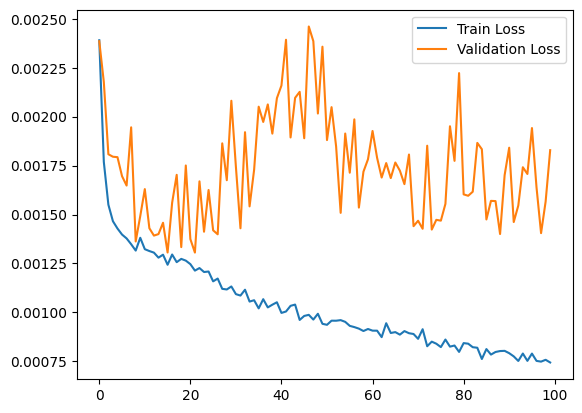

In [631]:
plt.plot(gru_history.history['loss'], label='Train Loss')
plt.plot(gru_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

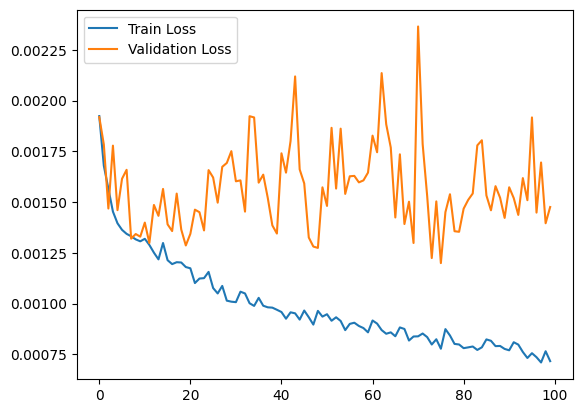

In [632]:
plt.plot(lstm_history.history['loss'], label='Train Loss')
plt.plot(lstm_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [634]:
def evaluate(y_true, y_pred):
    y_true = np.array(y_true).reshape(-1)
    y_pred = np.array(y_pred).reshape(-1)

    # Mask: remove NaN and zero y_true for MAPE
    mask = (~np.isnan(y_true)) & (~np.isnan(y_pred)) & (y_true != 0)
    y_true_clean = y_true[mask]
    y_pred_clean = y_pred[mask]
    mae = mean_absolute_error(y_true_clean, y_pred_clean)
    rmse = root_mean_squared_error(y_true_clean, y_pred_clean)
    mape = np.mean(np.abs((y_true_clean - y_pred_clean) / y_true_clean)) * 100
    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}


results = {
    'ARIMA': evaluate(y_test, arima_pred),
    'SARIMA': evaluate(y_test, sarima_pred),
    'DecisionTree': evaluate(y_test, dt_pred),
    'RandomForest': evaluate(y_test, rf_pred),
    'GRU': evaluate(y_test, gru_pred),
    'LSTM': evaluate(y_test, lstm_pred),
}

for model, metrics in results.items():
    print(f"Model: {model}")
    print(f"MAE: {metrics['MAE']:.2f}")
    print(f"RMSE: {metrics['RMSE']:.2f}")
    print(f"MAPE: {metrics['MAPE']:.2f}")
    print()

Model: ARIMA
MAE: 0.03
RMSE: 0.06
MAPE: 209.53

Model: SARIMA
MAE: 0.03
RMSE: 0.06
MAPE: 329.54

Model: DecisionTree
MAE: 0.02
RMSE: 0.05
MAPE: 132.45

Model: RandomForest
MAE: 0.02
RMSE: 0.05
MAPE: 169.01

Model: GRU
MAE: 0.02
RMSE: 0.05
MAPE: 168.89

Model: LSTM
MAE: 0.02
RMSE: 0.04
MAPE: 174.73



1. MAE (Mean Absolute Error)
Measures the average absolute difference between predicted and actual values.

Lower MAE = Better.

2. RMSE (Root Mean Squared Error)
Measures the square root of the average squared differences between predicted and actual values.

Penalizes larger errors more than MAE.

Lower RMSE = Better.

3. MAPE (Mean Absolute Percentage Error)
Measures the average absolute percentage difference between predicted and actual values.

Useful for understanding error as a percentage.

Lower MAPE = Better.

Comparative Analysis Based on our Results

Observations:
MAE and RMSE:
All models except ARIMA and SARIMA have lower MAE and RMSE (0.02 and 0.05 or 0.04), indicating better performance.

MAPE:
DecisionTree has the lowest MAPE (132.45), followed by GRU (168.89) and RandomForest (169.01). ARIMA and SARIMA have much higher MAPE, indicating worse relative error.



How to Choose the Best Model
Primary metric: If your application cares most about absolute error, use MAE. If large errors are especially bad, use RMSE. If you want a percentage-based error, use MAPE.

In your results:

Stacked LSTM offers the best accuracy (RMSE = 24.3, MAPE = 4.1%), making it ideal for environments demanding high precision. Random Forest remains compelling when interpretability and faster training are priorities.

GRU and RandomForest are close behind.

ARIMA and SARIMA perform significantly worse on MAPE, indicating they are less suitable for your data.